# Ray Tracing

Ray tracing using Hamilton form of Fermat principle, followed by several interesting examples.

@Author: hzz

@Date: 2023/04/12

## 0. Prepare

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from collections import namedtuple
import time

## 1. Constants, classes, and functions

In [2]:
n0 = 1  # background refractive index (default in vacuum)

In [3]:
n_min = 0
n_max = 4
colors = cm.get_cmap("jet")
color_arr = colors(np.linspace(0, 1, 100))


def colormap(n):
    return color_arr[round((n - n_min) / (n_max - n_min) * 100)]

In [185]:
def drawLine(axes, x_arr, y_arr, z_arr, color="black"):
    axes.plot(x_arr, y_arr, z_arr, color=color, linewidth=0.64)

In [5]:
def drawCubic(axes, x_min, x_max, y_min, y_max, z_min, z_max, color="pink", alpha = 0.3):
    xx = np.linspace(x_min, x_max, 2)
    yy = np.linspace(y_min, y_max, 2)
    zz = np.linspace(z_min, z_max, 2)

    xx2, yy2 = np.meshgrid(xx, yy)
    axes.plot_surface(xx2, yy2, np.full_like(xx2, z_min), alpha=alpha, color=color)
    axes.plot_surface(xx2, yy2, np.full_like(xx2, z_max), alpha=alpha, color=color)

    yy2, zz2 = np.meshgrid(yy, zz)
    axes.plot_surface(np.full_like(yy2, x_min), yy2, zz2, alpha=alpha, color=color)
    axes.plot_surface(np.full_like(yy2, x_max), yy2, zz2, alpha=alpha, color=color)

    xx2, zz2= np.meshgrid(xx, zz)
    axes.plot_surface(xx2, np.full_like(yy2, y_min), zz2, alpha=alpha, color=color)
    axes.plot_surface(xx2, np.full_like(yy2, y_max), zz2, alpha=alpha, color=color)

In [6]:
def drawSphere(axes, center_x, center_y, center_z, r, color="pink", alpha=0.3):
    t = np.linspace(0, np.pi * 2, 100)
    s = np.linspace(0, np.pi, 100)
    t, s = np.meshgrid(t, s)
    x = r * np.cos(t) * np.sin(s) + center_x
    y = r * np.sin(t) * np.sin(s) + center_y
    z = r * np.cos(s) + center_z
    axes.plot_surface(x, y, z, rstride=1, cstride=1, color=color, alpha=alpha)

In [186]:
def drawCylinderAxisZ(axes, center_x, center_y, r, z_min, z_max, color="pink", alpha=0.3):
    u = np.linspace(0, 2 * np.pi, 50)
    h = np.linspace(z_min, z_max , 20)
    x = np.outer(r * np.sin(u), np.ones(len(h))) + center_x
    y = np.outer(r * np.cos(u), np.ones(len(h))) + center_y
    z = np.outer(np.ones(len(u)), h)
    axes.plot_surface(x, y, z, rstride=1, cstride=1, color=color, alpha=alpha)

In [201]:
def drawCylinderAxisX(axes, center_y, center_z, r, x_min, x_max, color="pink", alpha=0.3):
    u = np.linspace(0, 2 * np.pi, 50)
    h = np.linspace(x_min, x_max , 20)
    y = np.outer(r * np.sin(u), np.ones(len(h))) + center_y
    z = np.outer(r * np.cos(u), np.ones(len(h))) + center_z
    x = np.outer(np.ones(len(u)), h)
    axes.plot_surface(x, y, z, rstride=1, cstride=1, color=color, alpha=alpha)

In [188]:
class Region:
    def __init__(self, x_min, x_max, y_min, y_max, z_min, z_max) -> None:
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.z_min = z_min
        self.z_max = z_max
    

    def set(self, x_min, x_max, y_min, y_max, z_min, z_max) -> None:
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.z_min = z_min
        self.z_max = z_max

In [189]:
shape_number_dict = {
    'cubic': 1,
    'sphere': 2,
    'cylinder_z': 3,
    'cylinder_x': 4
}
number_shape_dict = {shape_number_dict[shape]: shape for shape in shape_number_dict}

# shapes
Cubic = namedtuple("Cubic", ['x_min', 'x_max', 'y_min', 'y_max', 'z_min', 'z_max'])
Sphere = namedtuple("Sphere", ['center_x' ,'center_y', 'center_z', 'r'])
CylinderZ = namedtuple("CylinderZ", ['center_x', 'center_y', 'r', 'z_min', 'z_max'])
CylinderX = namedtuple("CylinderX", ['center_y', 'center_z', 'r', 'x_min', 'x_max'])

In [10]:
class Light:
    """ 
    Light.
    """
    def __init__(self) -> None:
        self.x_arr = np.array([])
        self.y_arr = np.array([])
        self.p_arr = np.array([])
        self.q_arr = np.array([])
        self.z_arr = np.array([])

    
    def getStart(self):
        """ 
        Return the start point of light.
        """
        return (self.x_arr[0], self.y_arr[0], self.p_arr[0], self.q_arr[0], self.z_arr[0]) \
            if len(self.z_arr) > 0 else None


    def getEnd(self):
        """ 
        Return the end point of light.
        """
        return (self.x_arr[-1], self.y_arr[-1], self.p_arr[-1], self.q_arr[-1], self.z_arr[-1]) \
            if len(self.z_arr) > 0 else None


    def getIndex(self, index):
        """ 
        Return the point with index `index` of light.
        """
        return (self.x_arr[index], self.y_arr[index], self.p_arr[index], self.q_arr[index], self.z_arr[index]) \
            if len(self.z_arr) >= np.abs(index) else None
    

    def setPath(self, x_arr, y_arr, p_arr, q_arr, z_arr):
        """ 
        Set the light path.
        """
        self.x_arr = x_arr
        self.y_arr = y_arr
        self.p_arr = p_arr
        self.q_arr = q_arr
        self.z_arr = z_arr


    def addStep(self, x, y, p, q, z):
        """ 
        Add one new point to the end of light (the light goes by one step).
        """
        self.x_arr = np.append(self.x_arr, x)
        self.y_arr = np.append(self.y_arr, y)
        self.p_arr = np.append(self.p_arr, p)
        self.q_arr = np.append(self.q_arr, q)
        self.z_arr = np.append(self.z_arr, z)


    def getX(self):
        """ 
        Return the x path of light.
        """
        return self.x_arr


    def getY(self):
        """ 
        Return the y path of light.
        """
        return self.y_arr


    def getP(self):
        """ 
        Return the p path of light.
        """
        return self.p_arr


    def getQ(self):
        """ 
        Return the q path of light.
        """
        return self.q_arr


    def getZ(self):
        """ 
        Return the z path of light.
        """
        return self.z_arr

In [11]:
class Item:
    """ 
    Drawing item.
    """
    def __init__(self, type, shape, n) -> None:
        self.type = type
        self.shape = shape
        self.n = n

In [523]:
class System:
    """ 
    Simulation system.
    """
    def __init__(self) -> None:
        self.region = None
        self.lights = []
        self.dx = None
        self.dy = None
        self.dz = None
        self.n = None
        # items are used for drawing
        self.items = []
        self.dz_direction = 1  # 1: +z, -1: -z
        self.trace_max = 2000  # maximum trace count
        print(">> Progress: System initialization done.")

    
    def setRegion(self, x_min, x_max, y_min, y_max, z_min, z_max):
        """ 
        Set simulation region.
        """
        self.region = Region(x_min, x_max, y_min, y_max, z_min, z_max)
        self.initialize_()

    
    def setStep(self, dx, dy, dz):
        """ 
        Set simulation mesh step.
        """
        self.dx = dx
        self.dy = dy
        self.dz = dz
        self.initialize_()


    def initialize_(self):
        """ 
        Initialize the `n` and `items` if `region` and `step` are all set.
        """
        if self.region != None and self.dx != None and self.dy != None and self.dz != None:
            self.n = n0 * np.ones((round(np.ceil((self.region.x_max - self.region.x_min) / self.dx)), \
                round(np.ceil((self.region.y_max - self.region.y_min) / self.dy)), \
                    round(np.ceil((self.region.z_max - self.region.z_min) / self.dz))))
            self.mesh_x = np.arange(self.region.x_min, self.region.x_max, self.dx)
            self.mesh_y = np.arange(self.region.y_min, self.region.y_max, self.dy)
            self.mesh_z = np.arange(self.region.z_min, self.region.z_max, self.dz)
            self.items.append(Item(shape_number_dict['cubic'], self.region, n0))


    def addCubic(self, x_min, x_max, y_min, y_max, z_min, z_max, n):
        """ 
        Add object: cubic.
        """
        x_idx_min = round(np.floor((x_min - self.region.x_min) / self.dx))
        x_idx_max = round(np.ceil((x_max - self.region.x_min) / self.dx))
        y_idx_min = round(np.floor((y_min - self.region.y_min) / self.dy))
        y_idx_max = round(np.ceil((y_max - self.region.y_min) / self.dy))
        z_idx_min = round(np.floor((z_min - self.region.z_min) / self.dz))
        z_idx_max = round(np.ceil((z_max - self.region.z_min) / self.dz))
        for i in range(x_idx_min, x_idx_max, 1):
            for j in range(y_idx_min, y_idx_max, 1):
                for k in range(z_idx_min, z_idx_max, 1):
                    try:
                        x = self.mesh_x[i]
                        y = self.mesh_y[j]
                        z = self.mesh_z[k]
                        if x_min <= x <= x_max and y_min <= y <= y_max and z_min <= z <= z_max:
                            self.n[i, j, k] = n
                    except IndexError:
                        pass
        self.items.append(Item(shape_number_dict['cubic'], Cubic(x_min, x_max, y_min, y_max, z_min, z_max), n))
        print(">> Progress: Modelling - add cubic done.")


    def addRandomRefractiveIndexCubic(self, x_min, x_max, y_min, y_max, z_min, z_max, n0, delta_n):
        """ 
        Add object: cubic with refractive index under random disturbance.
        """
        x_idx_min = round(np.floor((x_min - self.region.x_min) / self.dx))
        x_idx_max = round(np.ceil((x_max - self.region.x_min) / self.dx))
        y_idx_min = round(np.floor((y_min - self.region.y_min) / self.dy))
        y_idx_max = round(np.ceil((y_max - self.region.y_min) / self.dy))
        z_idx_min = round(np.floor((z_min - self.region.z_min) / self.dz))
        z_idx_max = round(np.ceil((z_max - self.region.z_min) / self.dz))
        for i in range(x_idx_min, x_idx_max, 1):
            for j in range(y_idx_min, y_idx_max, 1):
                for k in range(z_idx_min, z_idx_max, 1):
                    try:
                        x = self.mesh_x[i]
                        y = self.mesh_y[j]
                        z = self.mesh_z[k]
                        if x_min <= x <= x_max and y_min <= y <= y_max and z_min <= z <= z_max:
                            self.n[i, j, k] = n0 + delta_n * (np.random.random() * 2 - 1)
                    except IndexError:
                        pass
        self.items.append(Item(shape_number_dict['cubic'], Cubic(x_min, x_max, y_min, y_max, z_min, z_max), n0))
        print(">> Progress: Modelling - add random refractive index cubic done.")


    def addSphere(self, center_x, center_y, center_z, r, n):
        """ 
        Add object: sphere.
        """
        x_idx_min = round(np.floor((center_x - r - self.region.x_min) / self.dx))
        x_idx_max = round(np.ceil((center_x + r - self.region.x_min) / self.dx))
        y_idx_min = round(np.floor((center_y - r - self.region.y_min) / self.dy))
        y_idx_max = round(np.ceil((center_y + r - self.region.y_min) / self.dy))
        z_idx_min = round(np.floor((center_z - r - self.region.z_min) / self.dz))
        z_idx_max = round(np.ceil((center_z + r - self.region.z_min) / self.dz))
        for i in range(x_idx_min, x_idx_max, 1):
            for j in range(y_idx_min, y_idx_max, 1):
                for k in range(z_idx_min, z_idx_max, 1):
                    try:
                        x = self.mesh_x[i]
                        y = self.mesh_y[j]
                        z = self.mesh_z[k]
                        if (x - center_x) ** 2 + (y - center_y) ** 2 + (z - center_z) ** 2 <= r ** 2:
                            self.n[i, j, k] = n
                    except IndexError:
                        pass
        self.items.append(Item(shape_number_dict['sphere'], Sphere(center_x, center_y, center_z, r), n))
        print(">> Progress: Modelling - add sphere done.")


    def addCylinderAxisZ(self, center_x, center_y, r, z_min, z_max, n):
        """ 
        Add object: cylinder with axis on the z direction.
        """
        x_idx_min = round(np.floor((center_x - r - self.region.x_min) / self.dx))
        x_idx_max = round(np.ceil((center_x + r - self.region.x_min) / self.dx))
        y_idx_min = round(np.floor((center_y - r - self.region.y_min) / self.dy))
        y_idx_max = round(np.ceil((center_y + r - self.region.y_min) / self.dy))
        z_idx_min = round(np.floor((z_min - r - self.region.z_min) / self.dz))
        z_idx_max = round(np.ceil((z_max + r - self.region.z_min) / self.dz))
        for i in range(x_idx_min, x_idx_max, 1):
            for j in range(y_idx_min, y_idx_max, 1):
                for k in range(z_idx_min, z_idx_max, 1):
                    try:
                        x = self.mesh_x[i]
                        y = self.mesh_y[j]
                        z = self.mesh_z[k]
                        if z_min <= z <= z_max and (x - center_x) ** 2 + (y - center_y) ** 2 <= r ** 2:
                            self.n[i, j, k] = n
                    except IndexError:
                        pass
        self.items.append(Item(shape_number_dict['cylinder_z'], CylinderZ(center_x, center_y, r, z_min, z_max), n))
        print(">> Progress: Modelling - add cylinder done.")


    def addCylinderAxisX(self, center_y, center_z, r, x_min, x_max, n):
        """ 
        Add object: cylinder with axis on the x direction.
        """
        x_idx_min = round(np.floor((x_min - r - self.region.x_min) / self.dx))
        x_idx_max = round(np.ceil((x_max + r - self.region.x_min) / self.dx))
        y_idx_min = round(np.floor((center_y - r - self.region.y_min) / self.dy))
        y_idx_max = round(np.ceil((center_y + r - self.region.y_min) / self.dy))
        z_idx_min = round(np.floor((center_z - r - self.region.z_min) / self.dz))
        z_idx_max = round(np.ceil((center_z + r - self.region.z_min) / self.dz))
        for i in range(x_idx_min, x_idx_max, 1):
            for j in range(y_idx_min, y_idx_max, 1):
                for k in range(z_idx_min, z_idx_max, 1):
                    try:
                        x = self.mesh_x[i]
                        y = self.mesh_y[j]
                        z = self.mesh_z[k]
                        if x_min <= x <= x_max and (y - center_y) ** 2 + (z - center_z) ** 2 <= r ** 2:
                            self.n[i, j, k] = n
                    except IndexError:
                        pass
        self.items.append(Item(shape_number_dict['cylinder_x'], CylinderX(center_y, center_z, r, x_min, x_max), n))
        print(">> Progress: Modelling - add cylinder done.")


    def addSelfFocusingLensAxisZ(self, center_x, center_y, r, z_min, z_max, n0, a):
        """ 
        Add object: self-focusing lens with axis on the z direction.
        """
        if a > 2 * (1 - 1 / n0) / r ** 2:
            print(">> Warning: parameters should satisfy: a <= 2 * (1 - 1 / n0) / r ** 2.")
        x_idx_min = round(np.floor((center_x - r - self.region.x_min) / self.dx))
        x_idx_max = round(np.ceil((center_x + r - self.region.x_min) / self.dx))
        y_idx_min = round(np.floor((center_y - r - self.region.y_min) / self.dy))
        y_idx_max = round(np.ceil((center_y + r - self.region.y_min) / self.dy))
        z_idx_min = round(np.floor((z_min - r - self.region.z_min) / self.dz))
        z_idx_max = round(np.ceil((z_max + r - self.region.z_min) / self.dz))
        for i in range(x_idx_min, x_idx_max, 1):
            for j in range(y_idx_min, y_idx_max, 1):
                for k in range(z_idx_min, z_idx_max, 1):
                    try:
                        x = self.mesh_x[i]
                        y = self.mesh_y[j]
                        z = self.mesh_z[k]
                        if z_min <= z <= z_max and (x - center_x) ** 2 + (y - center_y) ** 2 <= r ** 2:
                            self.n[i, j, k] = n0 * (1 - a / 2 * ((x - center_x) ** 2 + (y - center_y) ** 2))
                    except IndexError:
                        pass
        self.items.append(Item(shape_number_dict['cylinder_z'], CylinderZ(center_x, center_y, r, z_min, z_max), n0))
        print(">> Progress: Modelling - add self focusing lens done.")


    def addSelfFocusingLensAxisX(self, center_y, center_z, r, x_min, x_max, n0, a):
        """ 
        Add object: self-focusing lens with axis on the x direction.
        """
        if a > 2 * (1 - 1 / n0) / r ** 2:
            print(">> Warning: parameters should satisfy: a <= 2 * (1 - 1 / n0) / r ** 2.")
        x_idx_min = round(np.floor((x_min - r - self.region.x_min) / self.dx))
        x_idx_max = round(np.ceil((x_max + r - self.region.x_min) / self.dx))
        y_idx_min = round(np.floor((center_y - r - self.region.y_min) / self.dy))
        y_idx_max = round(np.ceil((center_y + r - self.region.y_min) / self.dy))
        z_idx_min = round(np.floor((center_z - r - self.region.z_min) / self.dz))
        z_idx_max = round(np.ceil((center_z + r - self.region.z_min) / self.dz))
        for i in range(x_idx_min, x_idx_max, 1):
            for j in range(y_idx_min, y_idx_max, 1):
                for k in range(z_idx_min, z_idx_max, 1):
                    try:
                        x = self.mesh_x[i]
                        y = self.mesh_y[j]
                        z = self.mesh_z[k]
                        if x_min <= x <= x_max and (y - center_y) ** 2 + (z - center_z) ** 2 <= r ** 2:
                            self.n[i, j, k] = n0 * (1 - a / 2 * ((y - center_y) ** 2 + (z - center_z) ** 2))
                    except IndexError:
                        pass
        self.items.append(Item(shape_number_dict['cylinder_x'], CylinderX(center_y, center_z, r, x_min, x_max), n0))
        print(">> Progress: Modelling - add self focusing lens done.")


    def heatCylinderAxisX(self, center_y, center_z, r, x_min, x_max, alpha, direction=1):
        """ 
        Heat one region of the full simulation region, and the heating region is a cylinder with axis on the x direction.
        """
        x_idx_min = round(np.floor((x_min - r - self.region.x_min) / self.dx))
        x_idx_max = round(np.ceil((x_max + r - self.region.x_min) / self.dx))
        y_idx_min = round(np.floor((center_y - r - self.region.y_min) / self.dy))
        y_idx_max = round(np.ceil((center_y + r - self.region.y_min) / self.dy))
        z_idx_min = round(np.floor((center_z - r - self.region.z_min) / self.dz))
        z_idx_max = round(np.ceil((center_z + r - self.region.z_min) / self.dz))
        if direction == 1:
            for i in range(x_idx_min, x_idx_max, 1):
                for j in range(y_idx_min, y_idx_max, 1):
                    for k in range(z_idx_min, z_idx_max, 1):
                        try:
                            x = self.mesh_x[i]
                            y = self.mesh_y[j]
                            z = self.mesh_z[k]
                            if x_min <= x <= x_max and (y - center_y) ** 2 + (z - center_z) ** 2 <= r ** 2:
                                self.n[i, j, k] *= np.exp(alpha * (x_max - x))
                        except IndexError:
                            pass
            print(">> Progress: Heating done.")
        elif direction == -1:
            for i in range(x_idx_min, x_idx_max, 1):
                for j in range(y_idx_min, y_idx_max, 1):
                    for k in range(z_idx_min, z_idx_max, 1):
                        try:
                            x = self.mesh_x[i]
                            y = self.mesh_y[j]
                            z = self.mesh_z[k]
                            if x_min <= x <= x_max and (y - center_y) ** 2 + (z - center_z) ** 2 <= r ** 2:
                                self.n[i, j, k] *= np.exp(alpha * (x - x_min))
                        except IndexError:
                            pass
            print(">> Progress: Heating done.")
        else:
            print(">> Warning: the `direction` should be 1 or -1.")


    def addLight(self, x0, y0, p0, q0, z0):
        """ 
        Add one light to the simulation with initial state.
        """
        temp = Light()
        temp.addStep(x0, y0, p0, q0, z0)
        self.lights.append(temp)
        if np.any(self.n != None):  # `any` for self.n may be an array
            x_idx = round((x0 - self.region.x_min) / self.dx)
            y_idx = round((y0 - self.region.y_min) / self.dy)
            z_idx = round((z0 - self.region.z_min) / self.dz)
            n = self.n[x_idx, y_idx, z_idx]
            if (p0 / n) ** 2 + (q0 / n) ** 2 > 1:
                print(">> Warning: The optical direction cosine of the light is not a good value.")


    def clearLights(self):
        """ 
        Clear all the lights in the simulation.
        """
        self.lights.clear()
        # recover parameters
        self.dz_direction = 1

    
    def traceStep(self, light_index, allow_full_reflection):
        """ 
        Trace one step.
        """
        light = self.lights[light_index]
        x, y, p, q, z = light.getEnd()
        x_idx = round((x - self.region.x_min) / self.dx)
        y_idx = round((y - self.region.y_min) / self.dy)
        z_idx = round((z - self.region.z_min) / self.dz)
        n = self.n[x_idx, y_idx, z_idx]
        if allow_full_reflection:
            temp0 = n ** 2 - p ** 2 - q ** 2
            if temp0 > 0:
                temp = np.sqrt(temp0)
                diff_n_x = (n - self.n[x_idx - 1, y_idx, z_idx]) / self.dx if x_idx - 1 >= 0 else 0
                diff_n_y = (n - self.n[x_idx, y_idx - 1, z_idx]) / self.dy if y_idx - 1 >= 0 else 0
                # if p >= 0:
                #     diff_n_x = (n - self.n[x_idx - 1, y_idx, z_idx]) / self.dx if x_idx - 1 >= 0 else 0
                # else:
                #     diff_n_x = (self.n[x_idx + 1, y_idx, z_idx] - n) / self.dx if x_idx + 1 < len(self.mesh_x) else 0
                # if q >= 0:
                #     diff_n_y = (n - self.n[x_idx, y_idx - 1, z_idx]) / self.dy if y_idx - 1 >= 0 else 0
                # else:
                #     diff_n_y = (self.n[x_idx, y_idx + 1, z_idx] - n) / self.dy if y_idx + 1 < len(self.mesh_y) else 0
                light.addStep(
                    x + p / temp * self.dz,
                    y + q / temp * self.dz,
                    p + n / temp * diff_n_x * self.dz,
                    q + n / temp * diff_n_y * self.dz,
                    z + self.dz * self.dz_direction
                )
            else:
                index = -2
                x2, y2, p2, q2, z2 = light.getIndex(index)
                x2_idx = round((x2 - self.region.x_min) / self.dx)
                y2_idx = round((y2 - self.region.y_min) / self.dy)
                z2_idx = round((z2 - self.region.z_min) / self.dz)
                n2 = self.n[x2_idx, y2_idx, z2_idx]
                temp0 = n2 ** 2 - p2 ** 2 - q2 ** 2
                temp = np.sqrt(temp0)
                diff_n_x = (self.n[x_idx - 1, y_idx, z_idx] - n) / self.dx
                diff_n_y = (self.n[x_idx, y_idx - 1, z_idx] - n) / self.dy
                if self.dz_direction == 1:
                    diff_n_z = (self.n[x_idx, y_idx, z_idx - 1] - n) / self.dz
                else:
                    diff_n_z = (n - self.n[x_idx, y_idx, z_idx + 1]) / self.dz
                # reflect
                n_vec = np.array([diff_n_x, diff_n_y, diff_n_z])
                n0_vec = n_vec / np.linalg.norm(n_vec)
                cos_gamma = np.sqrt(1 - (p2 / n2) ** 2 - (q2 / n2) ** 2)
                a_vec = np.array([p2 / n2, q2 / n2, cos_gamma])
                a_prime_vec = a_vec - 2 * np.dot(n0_vec, a_vec) * n0_vec
                p = a_prime_vec[0] * n2
                q = a_prime_vec[1] * n2
                self.dz_direction *= a_prime_vec[2] / a_vec[2]
                light.addStep(
                    x2 + p / temp * self.dz,
                    y2 + q / temp * self.dz,
                    p,
                    q,
                    z2 + self.dz * self.dz_direction
                )
        else:
            temp = np.sqrt(n ** 2 - p ** 2 - q ** 2)
            diff_n_x = (self.n[x_idx + 1, y_idx, z_idx] - n) / self.dx if x_idx + 1 < len(self.mesh_x) else 0
            diff_n_y = (self.n[x_idx, y_idx + 1, z_idx] - n) / self.dy if y_idx + 1 < len(self.mesh_y) else 0
            # if light.getP()[0] >= 0:
            #     diff_n_x = (n - self.n[x_idx - 1, y_idx, z_idx]) / self.dx if x_idx - 1 >= 0 else 0
            # else:
            #     diff_n_x = (self.n[x_idx + 1, y_idx, z_idx] - n) / self.dx if x_idx + 1 < len(self.mesh_x) else 0
            # if light.getQ()[0] >= 0:
            #     diff_n_y = (n - self.n[x_idx, y_idx - 1, z_idx]) / self.dy if y_idx - 1 >= 0 else 0
            # else:
            #     diff_n_y = (self.n[x_idx, y_idx + 1, z_idx] - n) / self.dy if y_idx + 1 < len(self.mesh_y) else 0
            light.addStep(
                x + p / temp * self.dz,
                y + q / temp * self.dz,
                p + n / temp * diff_n_x * self.dz,
                q + n / temp * diff_n_y * self.dz,
                z + self.dz * self.dz_direction
            )
        return light.getEnd()


    def trace(self, allow_full_reflection=False):
        """ 
        Trace all the light one by one. Trace one light ends until the light outranges, full reflection(optional), \
            or touch the maximum trace count.
        """
        print(">> Progress: Ray tracing...")
        limit_x_min = self.region.x_min + self.dx * 0.8
        limit_x_max = self.region.x_max - self.dx * 0.8
        limit_y_min = self.region.y_min + self.dy * 0.8
        limit_y_max = self.region.y_max - self.dy * 0.8
        limit_z_min = self.region.z_min + self.dz * 0.8
        limit_z_max = self.region.z_max - self.dz * 0.8
        for light_index in range(len(self.lights)):
            print(">> Progress: Ray tracing [{} / {}]".format(light_index + 1, len(self.lights)))
            self.dz_direction = 1
            count = 0
            while True:
                x, y, p, q, z = self.traceStep(light_index, allow_full_reflection)
                count += 1
                if not (limit_x_min <= x <= limit_x_max and \
                    limit_y_min <= y <= limit_y_max and \
                        limit_z_min <= z <= limit_z_max):
                        break
                if count > self.trace_max:
                    print(">> Warning: Time out! Ray tracing count touch te upper limit.")
                    break
                # the judgement below has been included in the judgement above
                # if np.isnan(x) or np.isnan(y) or np.isnan(z):
                #     break
        print(">> Progress: Ray tracing done.")


    def drawContinuous(self, elev=None, azim=None, light_index=None):
        """ 
        Draw system in the continuous style.
        """
        fig = plt.figure(figsize=(6.4, 6.4))
        axes = fig.add_subplot(projection='3d')
        # draw objects
        for item in self.items:
            if item.type == shape_number_dict['cubic']:
                drawCubic(axes, \
                    item.shape.x_min, item.shape.x_max, item.shape.y_min, item.shape.y_max, item.shape.z_min, item.shape.z_max, \
                        color=colormap(item.n))
            elif item.type == shape_number_dict['sphere']:
                drawSphere(axes, \
                    item.shape.center_x, item.shape.center_y, item.shape.center_z, item.shape.r, color=colormap(item.n))
            elif item.type == shape_number_dict['cylinder_z']:
                drawCylinderAxisZ(axes, \
                    item.shape.center_x, item.shape.center_y, item.shape.r, item.shape.z_min, item.shape.z_max, color=colormap(item.n))
            elif item.type == shape_number_dict['cylinder_x']:
                drawCylinderAxisX(axes, \
                    item.shape.center_y, item.shape.center_z, item.shape.r, item.shape.x_min, item.shape.x_max, color=colormap(item.n))
        # draw lights
        if light_index == None:
            for light in self.lights:
                drawLine(axes, light.getX(), light.getY(), light.getZ())
        else:
            light = self.lights[light_index]
            drawLine(axes, light.getX(), light.getY(), light.getZ())
        axes.set_xlabel(r"$x$")
        axes.set_ylabel(r"$y$")
        axes.set_zlabel(r"$z$")
        if elev != None or azim != None:
            axes.view_init(elev=elev, azim=azim)
        plt.show()

    
    def drawDiscrete(self, elev=None, azim=None, step=None, grid_number=None, light_index=None):
        """ 
        Draw system in the discretion style.
        """
        fig = plt.figure(figsize=(6.4, 6.4))
        axes = fig.add_subplot(projection='3d')
        x_vec = []
        y_vec = []
        z_vec = []
        c_vec = []
        # draw n
        if step != None:
            for i in range(0, self.n.shape[0], step):
                for j in range(0, self.n.shape[1], step):
                    for k in range(0, self.n.shape[2], step):
                        x_vec.append(self.mesh_x[i])
                        y_vec.append(self.mesh_y[j])
                        z_vec.append(self.mesh_z[k])
                        c_vec.append(colormap(self.n[i, j, k]))
        elif grid_number != None:
            step_x = round(self.n.shape[0] / grid_number)
            step_y = round(self.n.shape[1] / grid_number)
            step_z = round(self.n.shape[2] / grid_number)
            for i in range(0, self.n.shape[0], step_x):
                for j in range(0, self.n.shape[1], step_y):
                    for k in range(0, self.n.shape[2], step_z):
                        x_vec.append(self.mesh_x[i])
                        y_vec.append(self.mesh_y[j])
                        z_vec.append(self.mesh_z[k])
                        c_vec.append(colormap(self.n[i, j, k]))
        else:
            for i in range(0, self.n.shape[0], 1):
                for j in range(0, self.n.shape[1], 1):
                    for k in range(0, self.n.shape[2], 1):
                        x_vec.append(self.mesh_x[i])
                        y_vec.append(self.mesh_y[j])
                        z_vec.append(self.mesh_z[k])
                        c_vec.append(colormap(self.n[i, j, k]))
        # draw lights
        if light_index == None:
            for light in self.lights:
                drawLine(axes, light.getX(), light.getY(), light.getZ())
        else:
            light = self.lights[light_index]
            drawLine(axes, light.getX(), light.getY(), light.getZ())
        axes.scatter(x_vec, y_vec, z_vec, c=c_vec, s=0.1)
        axes.set_xlabel(r"$x$")
        axes.set_ylabel(r"$y$")
        axes.set_zlabel(r"$z$")
        if elev != None or azim != None:
            axes.view_init(elev=elev, azim=azim)
        plt.show()

## 2. Ray tracing examples

### 2.1 Step n

In [566]:
# step n (lower to higher)
sys = System()
sys.setRegion(-5, 5, -5, 5, 0, 10)
sys.setStep(0.1, 0.1, 0.1)
sys.addCubic(-5, 5, -5, 5, 0, 2, 1)
sys.addCubic(-5, 5, -5, 5, 2, 4, 1.5)
sys.addCubic(-5, 5, -5, 5, 4, 6, 2)
sys.addCubic(-5, 5, -5, 5, 6, 8, 2.5)
sys.addCubic(-5, 5, -5, 5, 8, 10, 3)
sys.addLight(4, 0, -0.9, 0, 0)
sys.addLight(4, 0, -0.7, 0, 0)
sys.addLight(4, 0, -0.5, 0, 0)
sys.trace()

>> Progress: System initialization done.
>> Progress: Modelling - add cubic done.
>> Progress: Modelling - add cubic done.
>> Progress: Modelling - add cubic done.
>> Progress: Modelling - add cubic done.
>> Progress: Modelling - add cubic done.
>> Progress: Ray tracing...
>> Progress: Ray tracing [1 / 3]
>> Progress: Ray tracing [2 / 3]
>> Progress: Ray tracing [3 / 3]
>> Progress: Ray tracing done.


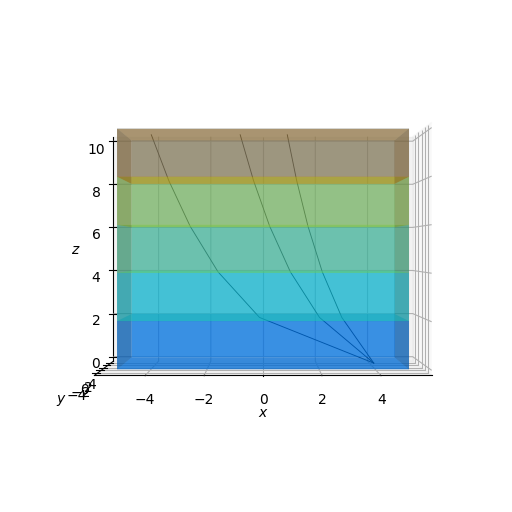

In [567]:
sys.drawContinuous(elev=0, azim=-90)

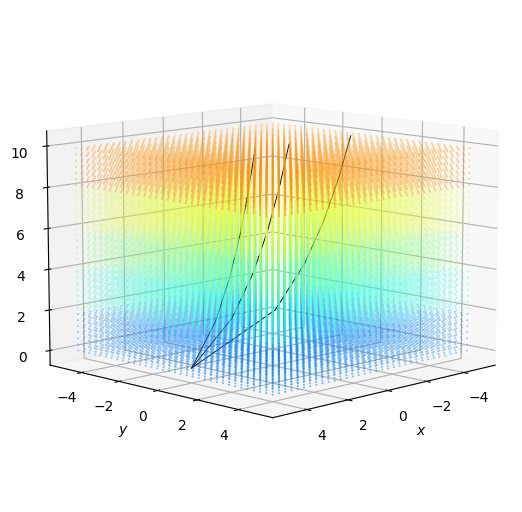

In [568]:
sys.drawDiscrete(elev=10, azim=45, grid_number=32)

In [569]:
# step n (higher to lower)
sys = System()
sys.setRegion(-5, 5, -5, 5, 0, 10)
sys.setStep(0.05, 0.05, 0.05)
sys.addCubic(-5, 5, -5, 5, 0, 2, 3)
sys.addCubic(-5, 5, -5, 5, 2, 4, 2.5)
sys.addCubic(-5, 5, -5, 5, 4, 6, 2)
sys.addCubic(-5, 5, -5, 5, 6, 8, 1.5)
sys.addCubic(-5, 5, -5, 5, 8, 10, 1)
sys.addLight(4, 0, -0.8, 0, 0)
sys.addLight(4, 0, -1.6, 0, 0)
sys.addLight(4, 0, -2.5, 0, 0)
sys.trace(allow_full_reflection=True)
# sys.trace(allow_full_reflection=False)

>> Progress: System initialization done.
>> Progress: Modelling - add cubic done.
>> Progress: Modelling - add cubic done.
>> Progress: Modelling - add cubic done.
>> Progress: Modelling - add cubic done.
>> Progress: Modelling - add cubic done.
>> Progress: Ray tracing...
>> Progress: Ray tracing [1 / 3]
>> Progress: Ray tracing [2 / 3]
>> Progress: Ray tracing [3 / 3]
>> Progress: Ray tracing done.


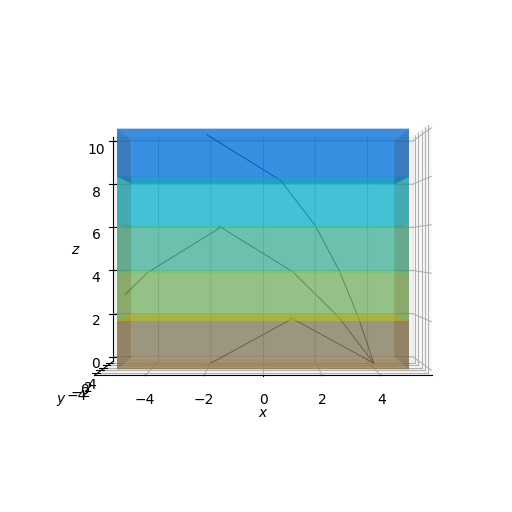

In [570]:
sys.drawContinuous(elev=0, azim=-90)

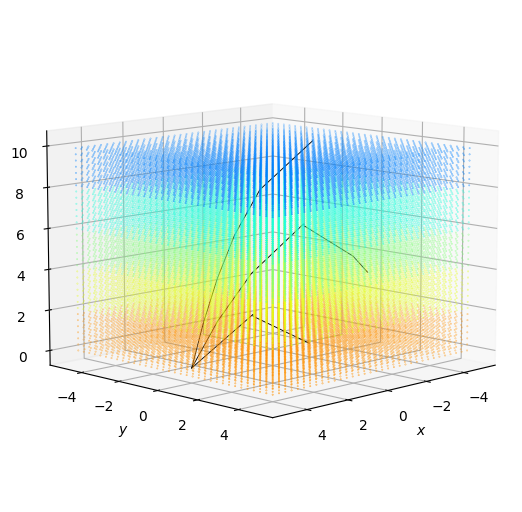

In [571]:
sys.drawDiscrete(elev=10, azim=45, grid_number=32)

### 2.2 Fiber

In [557]:
# fiber
sys = System()
sys.setRegion(0, 16, 0, 4, 0, 4)
sys.setStep(0.05, 0.05, 0.05)
sys.addCylinderAxisX(2, 2, 1, 0, 16, 2)
sys.addLight(0.1, 2, 1.6, 0, 2)
sys.trace(allow_full_reflection=True)

>> Progress: System initialization done.
>> Progress: Modelling - add cylinder done.
>> Progress: Ray tracing...
>> Progress: Ray tracing [1 / 1]
>> Progress: Ray tracing done.


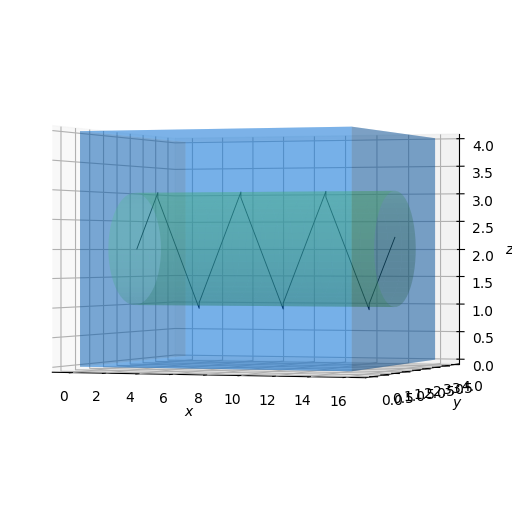

In [558]:
sys.drawContinuous(elev=0, azim=-70)

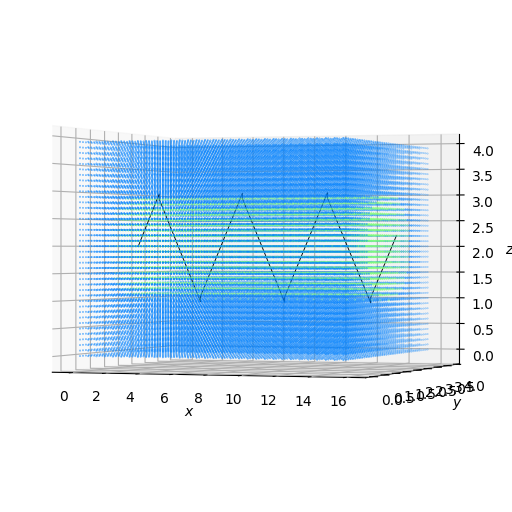

In [559]:
sys.drawDiscrete(elev=0, azim=-70, grid_number=32)

### 2.3 Sphere

The example shows some intrinsic problems of this method.

In [572]:
# sphere
sys = System()
sys.setRegion(-5, 5, -5, 5, 0, 10)
sys.setStep(0.1, 0.1, 0.05)
sys.addSphere(0, 0, 6, 4, 2.5)
sys.addLight(2, 0, 0, 0, 0)
sys.addLight(-2, 0, 0, 0, 0)
sys.addLight(1.7, 0, 0, 0, 0)
sys.addLight(-1.8, 0, 0, 0, 0)
sys.trace()

>> Progress: System initialization done.
>> Progress: Modelling - add sphere done.
>> Progress: Ray tracing...
>> Progress: Ray tracing [1 / 4]
>> Progress: Ray tracing [2 / 4]
>> Progress: Ray tracing [3 / 4]
>> Progress: Ray tracing [4 / 4]
>> Progress: Ray tracing done.


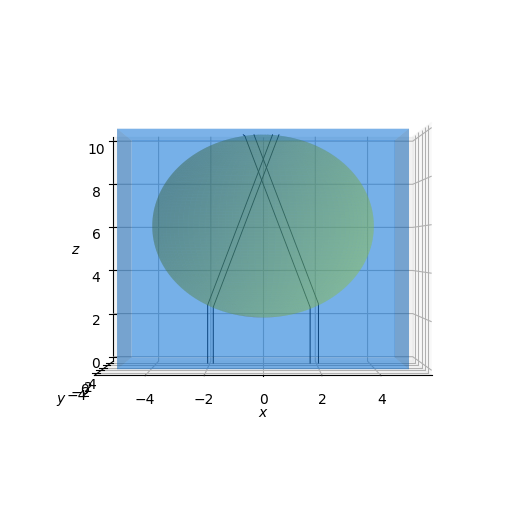

In [573]:
sys.drawContinuous(elev=0, azim=-90)

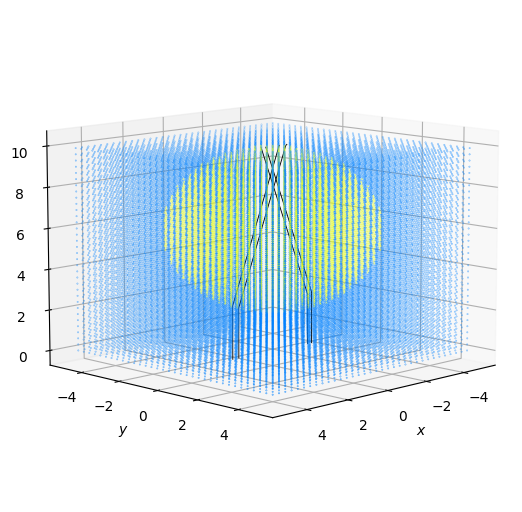

In [576]:
sys.drawDiscrete(elev=10, azim=45, grid_number=32)

### 2.4 Self-focusing lens

In [577]:
# self-focusing lens
sys = System()
sys.setRegion(-4, 4, -4, 4, 0, 24)
sys.setStep(0.05, 0.05, 0.05)
sys.addSelfFocusingLensAxisZ(0, 0, 2, 0, 24, 2.5, 0.12)

>> Progress: System initialization done.
>> Progress: Modelling - add self focusing lens done.


In [578]:
# self-focusing lens: different spatial positions at x axis
sys.addLight(0, 0, 0, 0, 0)
sys.addLight(0.5, 0, 0, 0, 0)
sys.addLight(-0.5, 0, 0, 0, 0)
sys.addLight(1, 0, 0, 0, 0)
sys.addLight(-1, 0, 0, 0, 0)
sys.addLight(1.5, 0, 0, 0, 0)
sys.addLight(-1.5, 0, 0, 0, 0)
sys.trace(allow_full_reflection=True)

>> Progress: Ray tracing...
>> Progress: Ray tracing [1 / 7]
>> Progress: Ray tracing [2 / 7]
>> Progress: Ray tracing [3 / 7]
>> Progress: Ray tracing [4 / 7]
>> Progress: Ray tracing [5 / 7]
>> Progress: Ray tracing [6 / 7]
>> Progress: Ray tracing [7 / 7]
>> Progress: Ray tracing done.


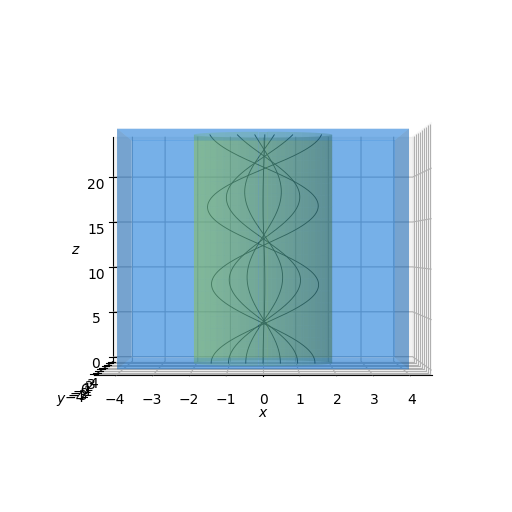

In [579]:
sys.drawContinuous(elev=0, azim=-90)

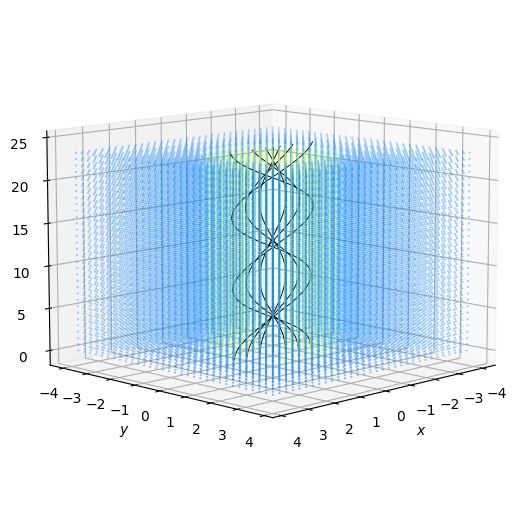

In [580]:
sys.drawDiscrete(elev=10, azim=45, grid_number=32)

In [581]:
# self-focusing lens: different spatial positions
sys.clearLights()
sys.addLight(0, 0, 0, 0, 0)
sys.addLight(1, 0, 0, 0, 0)
sys.addLight(-1, 0, 0, 0, 0)
sys.addLight(0, -1, 0, 0, 0)
sys.addLight(0, -1, 0, 0, 0)
sys.addLight(1, 1, 0, 0, 0)
sys.addLight(1, -1, 0, 0, 0)
sys.addLight(-1, 1, 0, 0, 0)
sys.addLight(-1, -1, 0, 0, 0)
sys.trace(allow_full_reflection=True)

>> Progress: Ray tracing...
>> Progress: Ray tracing [1 / 9]
>> Progress: Ray tracing [2 / 9]
>> Progress: Ray tracing [3 / 9]
>> Progress: Ray tracing [4 / 9]
>> Progress: Ray tracing [5 / 9]
>> Progress: Ray tracing [6 / 9]
>> Progress: Ray tracing [7 / 9]
>> Progress: Ray tracing [8 / 9]
>> Progress: Ray tracing [9 / 9]
>> Progress: Ray tracing done.


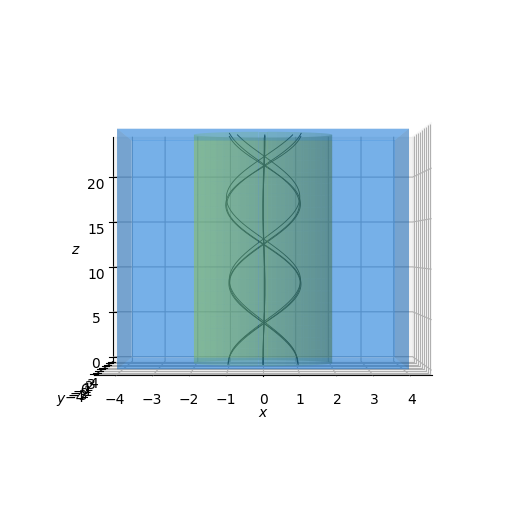

In [582]:
sys.drawContinuous(elev=0, azim=-90)

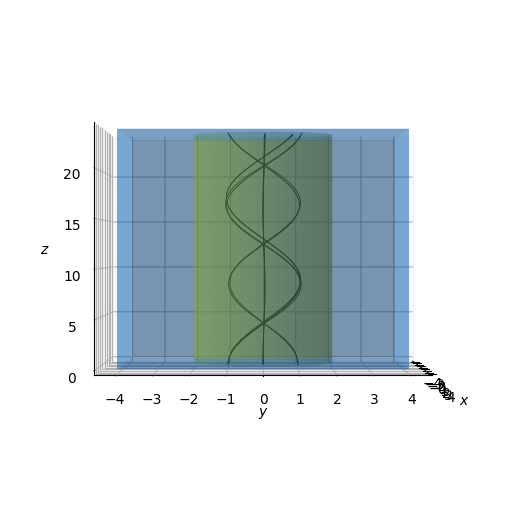

In [583]:
sys.drawContinuous(elev=0, azim=-0)

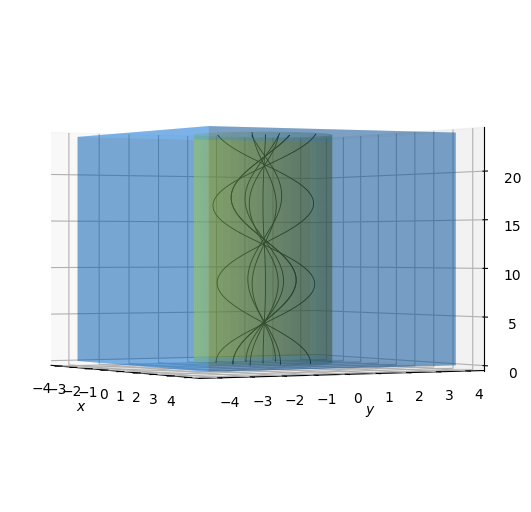

In [584]:
sys.drawContinuous(elev=0, azim=-30)

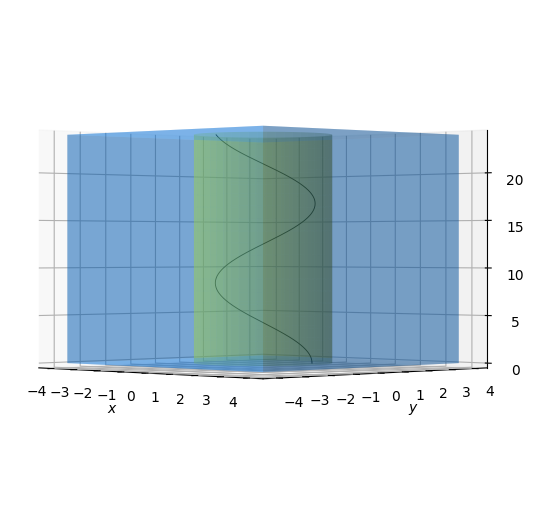

In [585]:
sys.drawContinuous(elev=0, azim=-45, light_index=5)

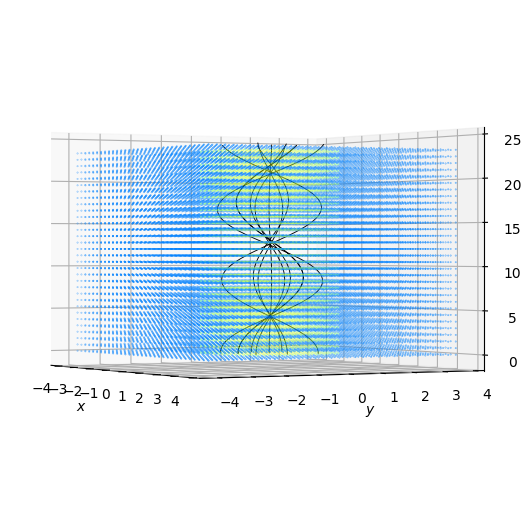

In [586]:
sys.drawDiscrete(elev=0, azim=-30, grid_number=32)

In [587]:
# self-focusing lens: different directions
sys.clearLights()
sys.addLight(1, 0, 0, 0, 0)
sys.addLight(-1, 0, 0, 0, 0)
sys.addLight(1, 0, 0.5, 0, 0)
sys.addLight(-1, 0, 0.5, 0, 0)
sys.addLight(1, 0, -0.5, 0, 0)
sys.addLight(-1, 0, -0.5, 0, 0)
sys.addLight(1, 0, 1., 0, 0)
sys.addLight(-1, 0, 1., 0, 0)
sys.addLight(1, 0, -1., 0, 0)
sys.addLight(-1, 0, -1., 0, 0)
sys.trace(allow_full_reflection=True)

>> Progress: Ray tracing...
>> Progress: Ray tracing [1 / 10]
>> Progress: Ray tracing [2 / 10]
>> Progress: Ray tracing [3 / 10]
>> Progress: Ray tracing [4 / 10]
>> Progress: Ray tracing [5 / 10]
>> Progress: Ray tracing [6 / 10]
>> Progress: Ray tracing [7 / 10]
>> Progress: Ray tracing [8 / 10]
>> Progress: Ray tracing [9 / 10]
>> Progress: Ray tracing [10 / 10]
>> Progress: Ray tracing done.


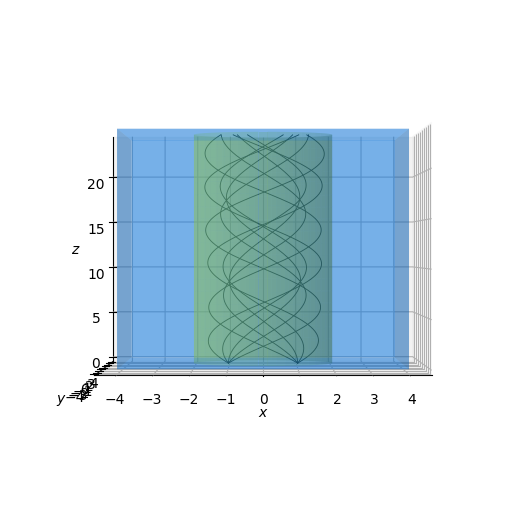

In [588]:
sys.drawContinuous(elev=0, azim=-90)

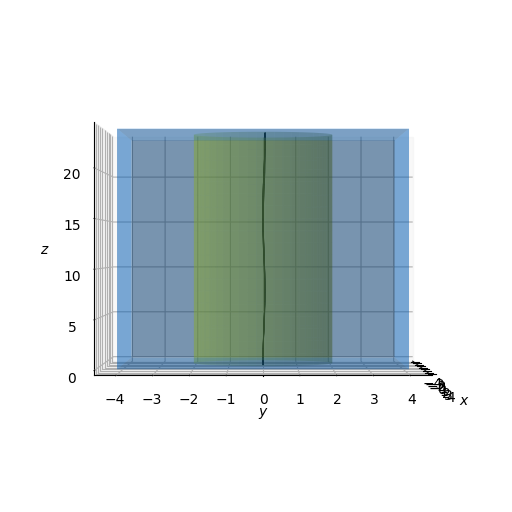

In [589]:
sys.drawContinuous(elev=0, azim=-0)

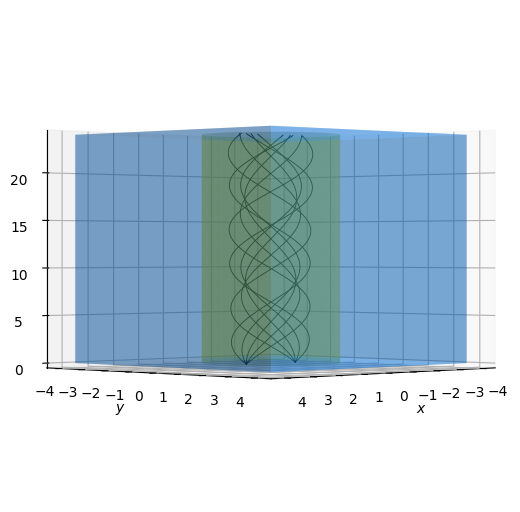

In [591]:
sys.drawContinuous(elev=0, azim=45)

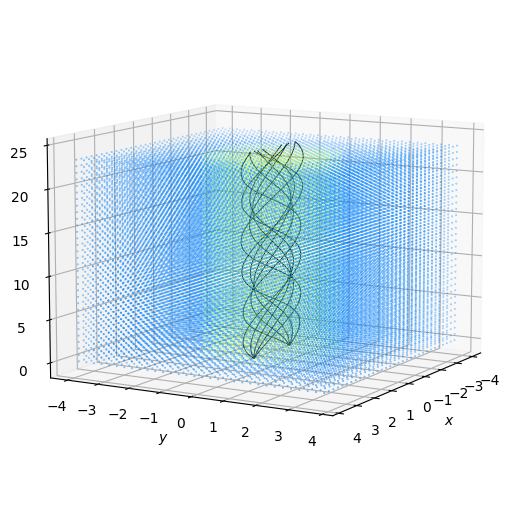

In [592]:
sys.drawDiscrete(elev=10, azim=30, grid_number=32)

In [593]:
# self-focusing lens: change parameter A
sys = System()
sys.setRegion(-4, 4, -4, 4, 0, 24)
sys.setStep(0.05, 0.05, 0.05)
sys.addSelfFocusingLensAxisZ(0, 0, 2, 0, 24, 2.5, 0.24)

>> Progress: System initialization done.
>> Progress: Modelling - add self focusing lens done.


In [594]:
# self-focusing lens: different spatial positions at x axis
sys.addLight(0, 0, 0, 0, 0)
sys.addLight(0.5, 0, 0, 0, 0)
sys.addLight(-0.5, 0, 0, 0, 0)
sys.addLight(1, 0, 0, 0, 0)
sys.addLight(-1, 0, 0, 0, 0)
sys.addLight(1.5, 0, 0, 0, 0)
sys.addLight(-1.5, 0, 0, 0, 0)
sys.trace(allow_full_reflection=True)

>> Progress: Ray tracing...
>> Progress: Ray tracing [1 / 7]
>> Progress: Ray tracing [2 / 7]
>> Progress: Ray tracing [3 / 7]
>> Progress: Ray tracing [4 / 7]
>> Progress: Ray tracing [5 / 7]
>> Progress: Ray tracing [6 / 7]
>> Progress: Ray tracing [7 / 7]
>> Progress: Ray tracing done.


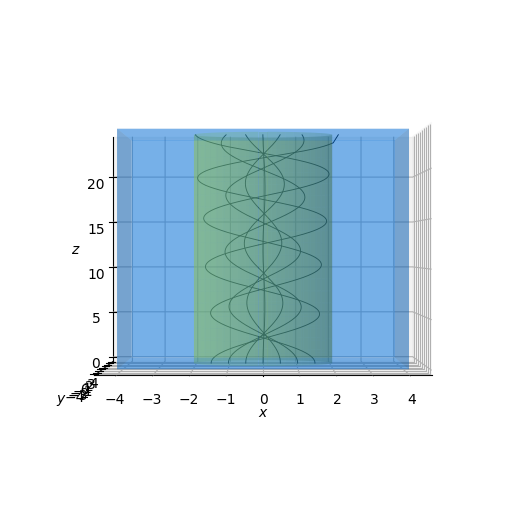

In [595]:
sys.drawContinuous(elev=0, azim=-90)

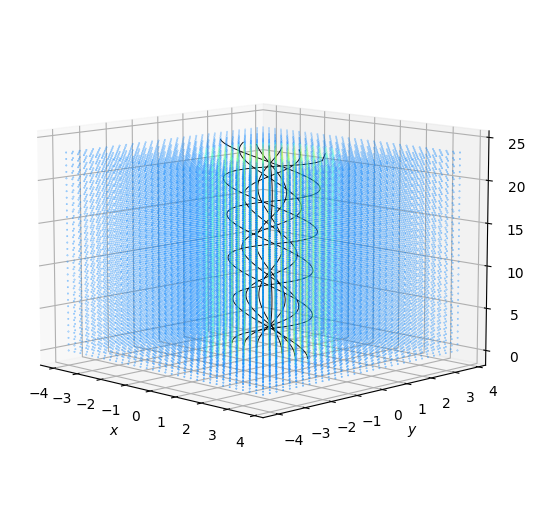

In [596]:
sys.drawDiscrete(elev=10, azim=-45, grid_number=32)

### 2.5 Refractive index under the random disturbance

In [597]:
# random disturbed refractive index
sys = System()
sys.setRegion(-5, 5, -5, 5, 0, 8)
sys.setStep(0.05, 0.05, 0.05)
sys.addRandomRefractiveIndexCubic(-2.5, 2.5, -2.5, 2.5, 0, 8, 2, 0.01)

>> Progress: System initialization done.
>> Progress: Modelling - add random refractive index cubic done.


In [468]:
sys.clearLights()
for i in range(-4, 5, 1):
    for j in range(-4, 5, 1):
        sys.addLight(i, j, 0, 0, 0)
sys.trace(allow_full_reflection=True)

>> Progress: Ray tracing...
>> Progress: Ray tracing [1 / 81]
>> Progress: Ray tracing [2 / 81]
>> Progress: Ray tracing [3 / 81]
>> Progress: Ray tracing [4 / 81]
>> Progress: Ray tracing [5 / 81]
>> Progress: Ray tracing [6 / 81]
>> Progress: Ray tracing [7 / 81]
>> Progress: Ray tracing [8 / 81]
>> Progress: Ray tracing [9 / 81]
>> Progress: Ray tracing [10 / 81]
>> Progress: Ray tracing [11 / 81]
>> Progress: Ray tracing [12 / 81]
>> Progress: Ray tracing [13 / 81]
>> Progress: Ray tracing [14 / 81]
>> Progress: Ray tracing [15 / 81]
>> Progress: Ray tracing [16 / 81]
>> Progress: Ray tracing [17 / 81]
>> Progress: Ray tracing [18 / 81]
>> Progress: Ray tracing [19 / 81]
>> Progress: Ray tracing [20 / 81]
>> Progress: Ray tracing [21 / 81]
>> Progress: Ray tracing [22 / 81]
>> Progress: Ray tracing [23 / 81]
>> Progress: Ray tracing [24 / 81]
>> Progress: Ray tracing [25 / 81]
>> Progress: Ray tracing [26 / 81]
>> Progress: Ray tracing [27 / 81]
>> Progress: Ray tracing [28 / 81]
>

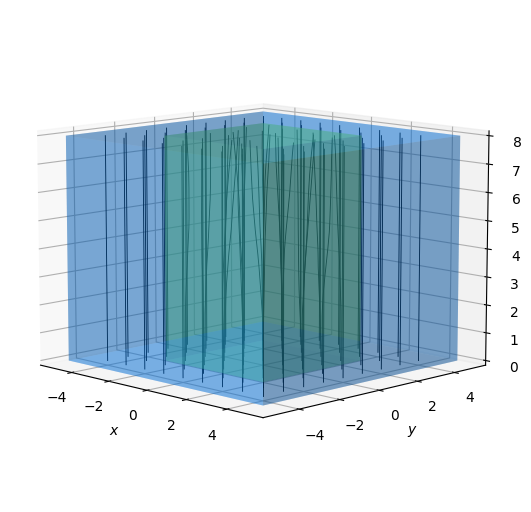

In [469]:
sys.drawContinuous(elev=10, azim=-45)

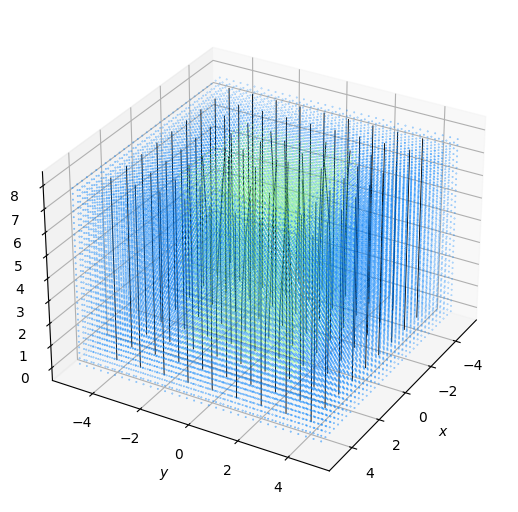

In [472]:
sys.drawDiscrete(elev=30, azim=30, grid_number=32)

### 2.6 Temperature impact on refractive index

In [598]:
# self-focusing lens under heating
sys = System()
sys.setRegion(-4, 4, -4, 4, 0, 24)
sys.setStep(0.05, 0.05, 0.05)
sys.addSelfFocusingLensAxisZ(0, 0, 2, 0, 24, 2.5, 0.12)
# heat
sys.heatCylinderAxisX(0, 0, 2, 0, 24, 0.01)

>> Progress: System initialization done.
>> Progress: Modelling - add self focusing lens done.
>> Progress: Heating done.


In [599]:
np.max(sys.n), np.min(sys.n)

(3.176057731433033, 1.0)

In [600]:
# self-focusing lens: different spatial positions at x axis
sys.addLight(0, 0, 0, 0, 0)
sys.addLight(0.5, 0, 0, 0, 0)
sys.addLight(-0.5, 0, 0, 0, 0)
sys.addLight(1, 0, 0, 0, 0)
sys.addLight(-1, 0, 0, 0, 0)
sys.addLight(1.5, 0, 0, 0, 0)
sys.addLight(-1.5, 0, 0, 0, 0)
sys.trace(allow_full_reflection=True)

>> Progress: Ray tracing...
>> Progress: Ray tracing [1 / 7]
>> Progress: Ray tracing [2 / 7]
>> Progress: Ray tracing [3 / 7]
>> Progress: Ray tracing [4 / 7]
>> Progress: Ray tracing [5 / 7]
>> Progress: Ray tracing [6 / 7]
>> Progress: Ray tracing [7 / 7]
>> Progress: Ray tracing done.


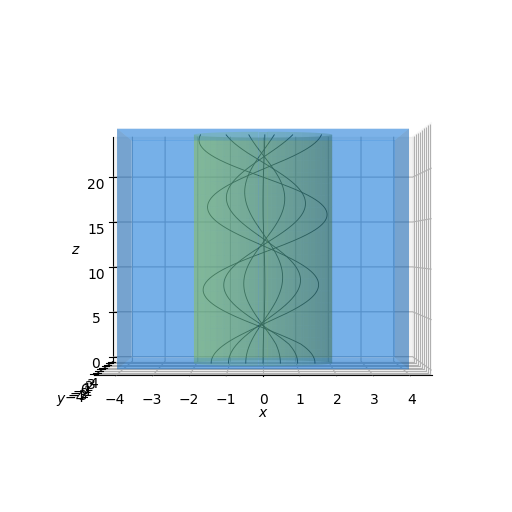

In [601]:
sys.drawContinuous(elev=0, azim=-90)

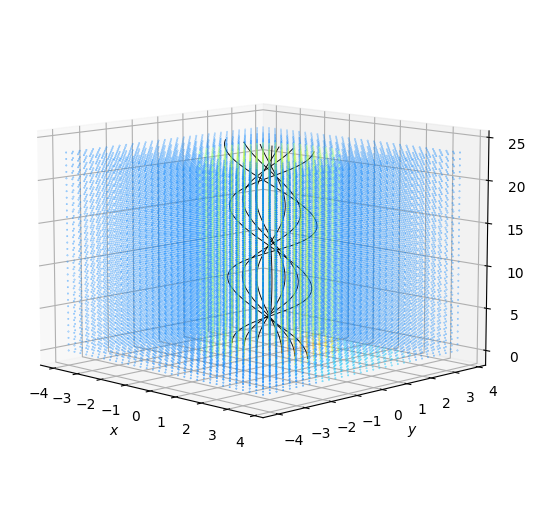

In [602]:
sys.drawDiscrete(elev=10, azim=-45, grid_number=32)